# 5. Predict_test

In [1]:
import time
import os
import pandas as pd

project_name = 'SceneClassification'
step_name = 'Predict_test_b'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

cwd = os.getcwd()
model_path = os.path.join(cwd, 'model')
feature_pca_file = os.path.join(model_path, 'feature_pca_SceneClassification_Dim_reduction_20171202_235958.h5')
print('model_path: ' + model_path)
print('feature_pca_file: ' + feature_pca_file)

run_name: SceneClassification_Predict_test_b_20171203_111500
model_path: E:\AIChallenger\SceneClassification2017\model
feature_pca_file: E:\AIChallenger\SceneClassification2017\model\feature_pca_SceneClassification_Dim_reduction_20171202_235958.h5


In [2]:
import h5py
import numpy as np

with h5py.File(feature_pca_file, 'r') as h:
    x_train = np.array(h['train'])
    y_train = np.array(h['train_label'])
    x_val = np.array(h['val'])
    y_val = np.array(h['val_label'])
    x_test_b = np.array(h['test_b'])

print(x_train.shape)
print(len(y_train))
print(x_val.shape)
print(len(y_val))
print(x_test_b.shape)

(53879, 512)
53879
(7120, 512)
7120
(7078, 512)


### Import pkg

In [3]:
import numpy as np
import pandas as pd
# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [5]:
# import zipfile
import os
import zipfile
import math
import time
from IPython.display import display
import pdb
import json
from PIL import Image
import glob
import pickle

### Load model

In [6]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
# from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3

In [7]:
model = load_model('./model/SceneClassification_Train_NN_20171203_105335_7779.h5')

## Predict validation
- Load image
- Resize image
- Predict
- Get top 1 or 3 or 5
- Calculate score

### Extract zip file

In [8]:
input_path = './input'
datasetName = 'test_b'
date = '20170922'

zip_path = input_path + '/ai_challenger_scene_{0}_{1}.zip'.format(datasetName, date)
extract_path = input_path + '/ai_challenger_scene_{0}_{1}'.format(datasetName, date)
image_path = extract_path + '/scene_{0}_images_{1}'.format(datasetName, date)
scene_classes_path = extract_path + '/scene_classes.csv'
scene_annotations_path = extract_path + '/scene_{0}_annotations_{1}.json'.format(datasetName, date)

print(input_path)
print(zip_path)
print(extract_path)
print(image_path)
print(scene_classes_path)
print(scene_annotations_path)

./input
./input/ai_challenger_scene_test_b_20170922.zip
./input/ai_challenger_scene_test_b_20170922
./input/ai_challenger_scene_test_b_20170922/scene_test_b_images_20170922
./input/ai_challenger_scene_test_b_20170922/scene_classes.csv
./input/ai_challenger_scene_test_b_20170922/scene_test_b_annotations_20170922.json


In [9]:
if not os.path.isdir(extract_path):
    with zipfile.ZipFile(zip_path) as file:
        for name in file.namelist():
            file.extract(name, input_path)

### Preview "scene_classes.csv"

In [10]:
scene_classes = pd.read_csv(scene_classes_path, header=None)
display(scene_classes.head())

,0,1,2
0,0,航站楼,airport_terminal
1,1,停机坪,landing_field
2,2,机舱,airplane_cabin
3,3,游乐场,amusement_park
4,4,冰场,skating_rink


In [11]:
def get_scene_name(lable_number, scene_classes_path):
    scene_classes = pd.read_csv(scene_classes_path, header=None)
    return scene_classes.loc[lable_number, 2]
print(get_scene_name(0, scene_classes_path))

airport_terminal


### Build functions

(1, 224, 224, 3)


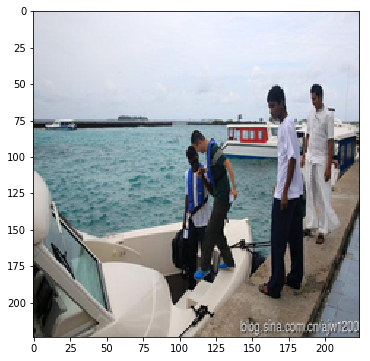

In [12]:
def process_image(image_path, fileName):
    box = (224, 224)
    img_path = image_path + '/' + fileName
    img = Image.open(img_path)
    img1 = img.resize(box, Image.ANTIALIAS) # resizes image in-place
    imgData = np.asarray(img1)
    imgData = imgData.astype("float32")
    imgData = imgData/255.0
    x = np.expand_dims(imgData, axis=0)
    return x

test_img = process_image(image_path, '000f0066a10c1e6b3681c4ca662388e916629040.jpg')
print(test_img.shape)
# print(x)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(test_img[0])

In [13]:
def decode_predictions(pred, top=3, isPreview=False):
    top_indices = pred.argsort()[-top:][::-1]
    if not isPreview:
        return top_indices
    results  = []
    for i in top_indices:
        result = (i, pred[i])
        results.append(result)
    return results
pred = np.array([3, -1, 2, 7, -2, -1, 0, 6, -9])
print(decode_predictions(pred))
print(decode_predictions(pred, top=5))
print(decode_predictions(pred, top=8, isPreview=True))

[3 7 0]
[3 7 0 2 6]
[(3, 7), (7, 6), (0, 3), (2, 2), (6, 0), (5, -1), (1, -1), (4, -2)]


In [14]:
preds = model.predict(x_test_b)
print(preds[0])
print(decode_predictions(preds[0]))
print(decode_predictions(preds[0], top=5, isPreview=True))
lable_id = decode_predictions(preds[0])[0]
print("label_id:{0} lable_text:{1}".format(lable_id, get_scene_name(lable_id, scene_classes_path)))

[  4.46163000e-08   4.07461931e-09   2.46847498e-09   4.17441839e-07
   6.86355790e-08   1.88041938e-08   1.20317232e-08   9.75378072e-08
   1.06904385e-09   3.15330179e-10   3.66487091e-10   7.02387315e-11
   2.61821231e-09   2.80543011e-09   4.31114033e-09   9.93647609e-10
   6.15336282e-10   7.07326697e-11   6.14085957e-06   9.67723332e-11
   9.10587517e-08   2.61282607e-04   8.10939412e-07   6.10940617e-07
   2.20381259e-03   1.20681349e-07   3.97073752e-09   5.24374606e-08
   1.30960780e-05   3.61983439e-07   1.27256161e-08   9.24418375e-10
   2.25224339e-05   1.22389486e-06   7.18537834e-08   9.49155332e-09
   9.89177920e-07   1.02479891e-08   1.26181765e-09   2.94025213e-08
   1.10721354e-09   5.51811397e-09   6.67444855e-09   1.17937616e-05
   1.45304979e-09   1.52613580e-07   7.27744846e-05   3.36915514e-06
   2.34560815e-09   2.46530956e-08   1.43026261e-06   1.41710759e-08
   1.41778287e-07   1.03840895e-04   1.63302730e-07   3.90312532e-10
   7.83033465e-05   8.63251273e-07

In [15]:
%%time
results = []
count = 10000 # For test
if os.path.isdir(image_path):
    files = os.listdir(image_path)
    image_amount = len(files)
    print('Image amount:{}'.format(image_amount))
    i = 0
    for file in files:
#         print(file)
#         print(image_path + '/' + file)
#         test_img = process_image(image_path, file)
#         pred = model.predict(test_img)
        labels = decode_predictions(preds[i])
        i += 1
        result = {}
        result['label_id'] = labels.tolist()
        result['image_id'] = file
        results.append(result)
        count = count -1
        if count <= 0:
            break

# print(results)
output_path = os.path.join(cwd, 'output')
if not os.path.exists(output_path):
    os.mkdir(output_path)
submit_file = './output' + '/submit' + time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime()) + '.json'
print(submit_file)
with open(submit_file, 'w') as f:
    json.dump(results, f)
    result_amount = len(result)
    print('Image amount:{0}, result amount:{1}'.format(image_amount, result_amount))

Image amount:7078
./output/submit2017-12-03_11-15-07.json
Image amount:7078, result amount:2
Wall time: 329 ms


In [16]:
%run ./scene_classification_eval/scene_eval.py --submit ./scene_classification_eval/submit.json --ref ./scene_classification_eval/ref.json

warnning: lacking image 7df98fcd7a85281f845910af403ba65ca1494b60.jpg in your submission file
Evaluation time of your result: 0.000000 s
{'error': [], 'warning': ['Inconsistent number of images between submission and reference data \n', 'lacking image 7df98fcd7a85281f845910af403ba65ca1494b60.jpg in your submission file \n'], 'score': '0.8'}


In [17]:
# %%time
%run ./scene_classification_eval/scene_eval.py --submit ./output/submit2017-12-03_11-13-54.json  --ref ./output/scene_validation_annotations_20170908.json

Evaluation time of your result: 0.015700 s
{'error': ["[Errno 2] No such file or directory: './output/scene_validation_annotations_20170908.json'"], 'warning': [], 'score': '0.0'}
